In [1]:
### RESEARCH : CRAFT PAPER IMPLEMENTATION
# UPDATED AT : 2023-03-01
# CREATED AT : 2023-03-01
# RESEARCHER : Park Hyun Ho
# REFERENCE  : https://github.com/clovaai/CRAFT-pytorch
## PRETRAIN  : https://drive.google.com/file/d/1Jk4eGD7crsqCCg9C9VjCLkMN3ze8kutZ/view

In [36]:
'''
LIBRARY IMPLEMENTATION 
'''

import sys
import os
import time
import argparse

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

from PIL import Image

import cv2
from skimage import io
import numpy as np
import craft_utils
import imgproc
import file_utils
import json
import zipfile

from craft import CRAFT

from collections import OrderedDict

import gc

import warnings
warnings.filterwarnings('ignore')

print(f"LIBRARY IMPORTED....")

LIBRARY IMPORTED....


In [3]:
'''
FUNCTION
'''

def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict

def str2bool(v):
    return v.lower() in ("yes", "y", "true", "t", "1")


def test_net(net, image, text_threshold, link_threshold, low_text, cuda, poly, refine_net=None):
    t0 = time.time()

    # resize
    img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(image, args.canvas_size, interpolation=cv2.INTER_LINEAR, mag_ratio=args.mag_ratio)
    ratio_h = ratio_w = 1 / target_ratio

    # preprocessing
    x = imgproc.normalizeMeanVariance(img_resized)
    x = torch.from_numpy(x).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
    x = Variable(x.unsqueeze(0))                # [c, h, w] to [b, c, h, w]
    if cuda:
        x = x.cuda()

    # forward pass
    with torch.no_grad():
        y, feature = net(x)


    # make score and link map
    score_text = y[0,:,:,0].cpu().data.numpy()
    score_link = y[0,:,:,1].cpu().data.numpy()

    # refine link
    if refine_net is not None:
        with torch.no_grad():
            y_refiner = refine_net(y, feature)
        score_link = y_refiner[0,:,:,0].cpu().data.numpy()

    t0 = time.time() - t0
    t1 = time.time()

    # Post-processing
    boxes, polys = craft_utils.getDetBoxes(score_text, score_link, text_threshold, link_threshold, low_text, poly)

    # coordinate adjustment
    boxes = craft_utils.adjustResultCoordinates(boxes, ratio_w, ratio_h)
    polys = craft_utils.adjustResultCoordinates(polys, ratio_w, ratio_h)
    for k in range(len(polys)):
        if polys[k] is None: polys[k] = boxes[k]

    t1 = time.time() - t1

    # render results (optional)
    render_img = score_text.copy()
    render_img = np.hstack((render_img, score_link))
    ret_score_text = imgproc.cvt2HeatmapImg(render_img)

    if args.show_time : print("\ninfer/postproc time : {:.3f}/{:.3f}".format(t0, t1))

    return boxes, polys, ret_score_text


In [4]:
'''
SET PARAMETERS
'''

parser = argparse.ArgumentParser(description='CRAFT Text Detection')

parser.add_argument('--trained_model', default='./weights/craft_mlt_25k.pth', type=str, help='pretrained model')
parser.add_argument('--text_threshold', default=0.7, type=float, help='text confidence threshold')
parser.add_argument('--low_text', default=0.4, type=float, help='text low-bound score')
parser.add_argument('--link_threshold', default=0.4, type=float, help='link confidence threshold')
parser.add_argument('--cuda', default=False, type=str2bool, help='Use cuda for inference')
parser.add_argument('--canvas_size', default=1280, type=int, help='image size for inference')
parser.add_argument('--mag_ratio', default=1.5, type=float, help='image magnification ratio')
parser.add_argument('--poly', default=False, action='store_true', help='enable polygon type')
parser.add_argument('--show_time', default=False, action='store_true', help='show processing time')
parser.add_argument('--test_folder', default='./test_image/', type=str, help='folder path to input images')
parser.add_argument('--refine', default=False, action='store_true', help='enable link refiner')
parser.add_argument('--refiner_model', default='weights/craft_refiner_CTW1500.pth', type=str, help='pretrained refiner model')

'''
When use parse_args() error evocked...

'''
args, unknown = parser.parse_known_args()


Target Image : ['./test_image/chinese.jpg', './test_image/korean_japan.jpg']

NAME : ./test_image/chinese.jpg...


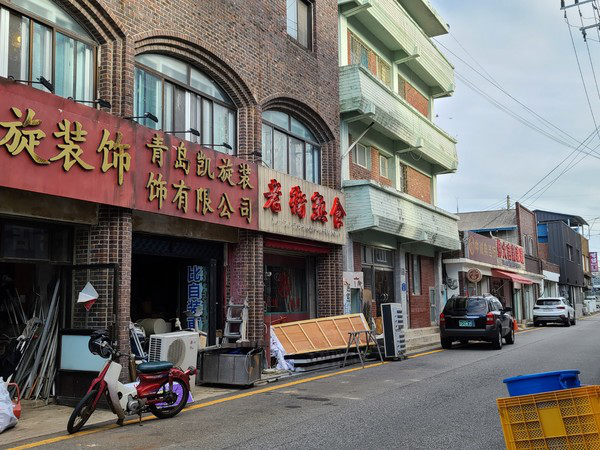


NAME : ./test_image/korean_japan.jpg...


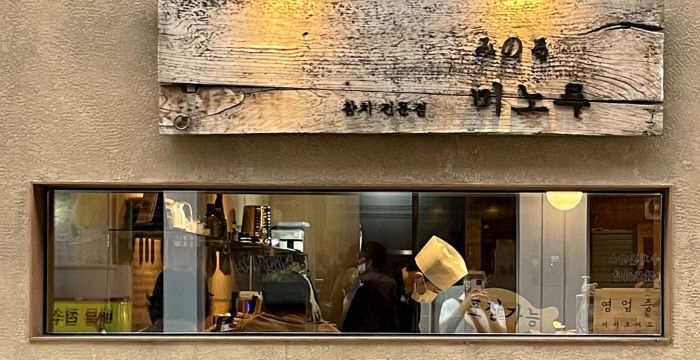

In [37]:
""" For test images in a folder """
image_list, _, _ = file_utils.get_files(args.test_folder)

result_folder = './result/'
if not os.path.isdir(result_folder):
    os.mkdir(result_folder)

print(f'Target Image : {image_list}')

for image_ in image_list:
    print(f'\nNAME : {image_}...')
    im = Image.open(image_)
    display(im)

In [42]:
'''
APPLY CRAFT
'''

if __name__ == '__main__':
    # load net
    net = CRAFT()     # initialize

    print('Loading weights from checkpoint (' + args.trained_model + ')')
    if args.cuda:
        net.load_state_dict(copyStateDict(torch.load(args.trained_model)))
    else:
        net.load_state_dict(copyStateDict(torch.load(args.trained_model, map_location='cpu')))

    if args.cuda:
        net = net.cuda()
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = False

    net.eval()

    # LinkRefiner
    refine_net = None
    if args.refine:
        from refinenet import RefineNet
        refine_net = RefineNet()
        print('Loading weights of refiner from checkpoint (' + args.refiner_model + ')')
        if args.cuda:
            refine_net.load_state_dict(copyStateDict(torch.load(args.refiner_model)))
            refine_net = refine_net.cuda()
            refine_net = torch.nn.DataParallel(refine_net)
        else:
            refine_net.load_state_dict(copyStateDict(torch.load(args.refiner_model, map_location='cpu')))

        refine_net.eval()
        args.poly = True

    return_list = list()

    t = time.time()

    # load data
    for k, image_path in enumerate(image_list):
        print("Test image {:d}/{:d}: {:s}".format(k+1, len(image_list), image_path), end='\r')
        image = imgproc.loadImage(image_path)

        bboxes, polys, score_text = test_net(net, image, args.text_threshold, args.link_threshold, args.low_text, args.cuda, args.poly, refine_net)

        # save score text
        filename, file_ext = os.path.splitext(os.path.basename(image_path))
        mask_file = result_folder + "/res_" + filename + '_mask.jpg'
        cv2.imwrite(mask_file, score_text)

        file_utils.saveResult(image_path, image[:,:,::-1], polys, dirname=result_folder)
        return_list.append(filename)

    print("elapsed time : {}s".format(time.time() - t))

print(f'\nDONE....')

Loading weights from checkpoint (./weights/craft_mlt_25k.pth)
elapsed time : 4.282011032104492san_japan.jpg

DONE....


Result image 1/2
Original Image : chinese....


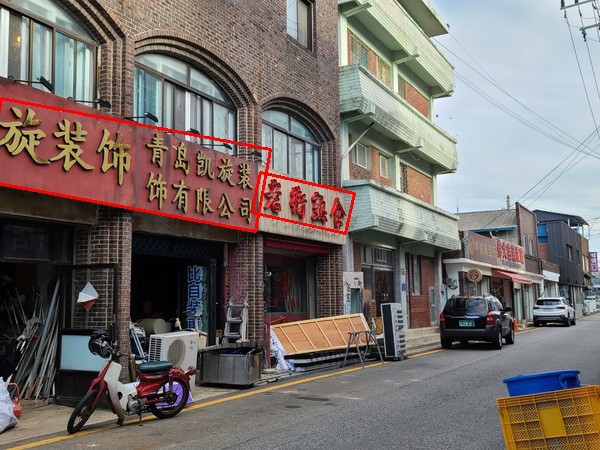

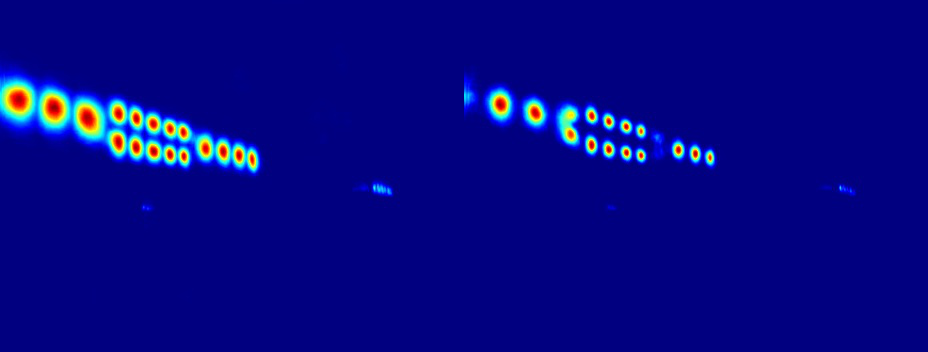

Result image 2/2
Original Image : korean_japan....


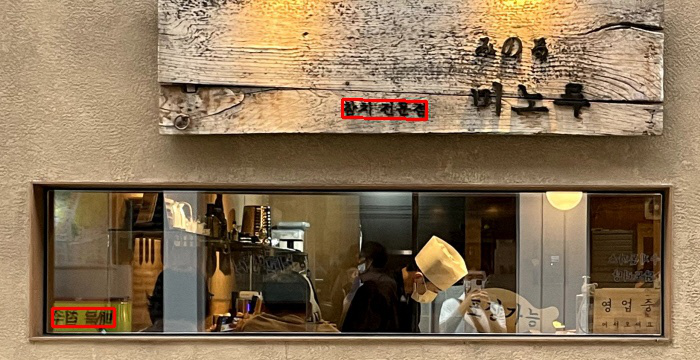

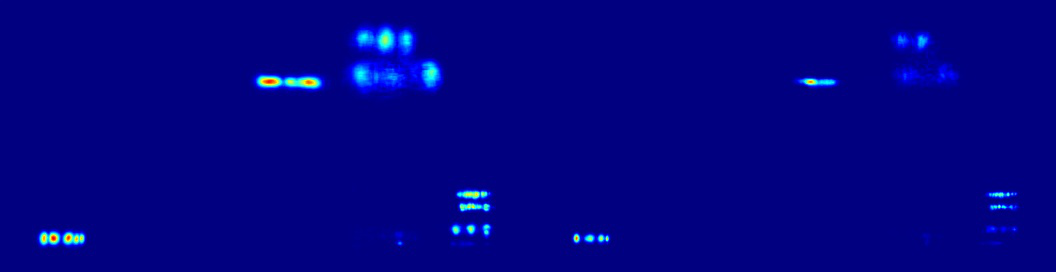

DONE....


In [44]:
for idx, return_ in enumerate(return_list):
    print(f"Result image {idx+1}/{len(return_list)}")
    print(f'Original Image : {return_}....')
    original_file = result_folder + "/res_" + return_ + '.jpg'
    mask_file = result_folder + "/res_" + return_ + '_mask.jpg'

    im_original = Image.open(original_file)
    display(im_original)

    im = Image.open(mask_file)
    display(im)

print(f'DONE....')